In [64]:
import os
import sys

import argparse
import shutil
import time

import math
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.model_zoo as model_zoo
import torchvision.models as models

from torchviz import make_dot
import matplotlib.pyplot as plt
import graphviz

from pathlib import Path



# Model Specifics
# import pytorch_resnet as R
import BaseModel as B
import CDDSM
from tqdm import tqdm,tqdm_notebook

import logging



#Device Selection
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
num_epochs = 5
num_classes = 3
batch_size = 4
learning_rate = 0.001

def pause(strg):
    if(strg!=''):
        print('Reached at {}, Press any key to continue'.format(strg))
    else:
        print('Paused, Press any to continue')
    input()
    return

# x = torch.randn(batch_size, channels_mammo,heights_mammo , width_mammo)

# Reading Standard CSV files by TCIA for test/train

In [65]:
# device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device ='cpu'
num_epochs = 100
num_classes = 3
batch_size = 2
learning_rate = 0.0001

total_iteration = 10000
img_resize =H=W=512


homedir = str(Path.home())
homedir

train_df = CDDSM.createTrainFrame(homedir)
test_df = CDDSM.createTestFrame(homedir)
mammogram_dir = '/home/himanshu/CuratedDDSM/'
train_file = mammogram_dir+'train.csv'
test_file = mammogram_dir+'test.csv'
train_df.to_csv(train_file)
test_df.to_csv(test_file)

classes = ('BENIGN', 'BENIGN_WITHOUT_CALLBACK', 'MALIGNANT')
                

# Making of CBIS-DDSM Dataset (train,val,test)

In [66]:
dataset =  CDDSM.MammographyDataset(train_file,homedir,img_resize)
test_dataset = CDDSM.MammographyDataset(test_file,homedir,img_resize)

train_dataset , val_dataset = CDDSM.trainValSplit(dataset,val_share=0.98)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)

test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=batch_size, 
                                          shuffle=False)

# Length of each Dataset

In [67]:
numberOfTrainData = train_dataset.__len__()
numberOfValData = val_dataset.__len__()
numberOfTestData =  test_dataset.__len__()

total_step=len(train_loader)

print('Size of training dataset {}'.format(numberOfTrainData))
print('Size of Validation dataset {}'.format(numberOfValData))
print('Size of testing dataset {}'.format(numberOfTestData))
print('No. of Epochs: {}\n Batch size: {}\n Learning_rate : {}\n Image size {}*{}\n Step {}'
        .format(num_epochs,batch_size,learning_rate,H,W,total_step))

Size of training dataset 57
Size of Validation dataset 2807
Size of testing dataset 704
No. of Epochs: 100
 Batch size: 2
 Learning_rate : 0.0001
 Image size 512*512
 Step 29


# Checking images in each dataset by making grid

# trainDataset

BENIGN BENIGN


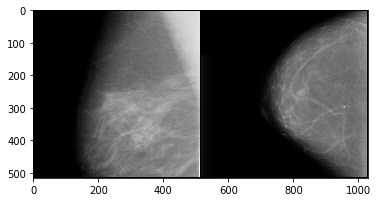

In [68]:
trainloader = train_loader
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# val Dataset

BENIGN BENIGN


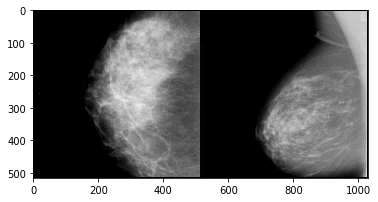

In [69]:
trainloader = val_loader
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# test Dataset

MALIGNANT MALIGNANT


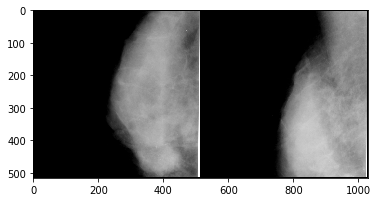

In [70]:
trainloader = test_loader
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

# Get Model

In [71]:
import torchvision.models as models
resnet = models.resnet18(pretrained=True)


# removing last layer of resnet and grad false

resnet = nn.Sequential(*list(resnet.children())[:-1])


for param in resnet.parameters():
    param.requires_grad = False
    
    
class myCustomModel(torch.nn.Module):
    def __init__(self,pretrainedModel):
        super(myCustomModel,self).__init__()
        
        self.layer0 = nn.Sequential()
        self.layer0.add_module('conv0',nn.Conv2d(1,3,kernel_size=9,stride=1,padding=0,dilation=8))
        self.layer0.add_module('relu0',nn.ReLU())
        self.layer0.add_module('maxpool',nn.MaxPool2d(kernel_size=2))
        self.layer1 = nn.Sequential()
        self.layer1.add_module('pretrained',pretrainedModel)
        self.fc = nn.Linear(in_features=512,out_features=3)
    def forward(self,x):
        x = self.layer0(x)
        features = self.layer1(x)
        features = features.view(features.size(0), -1)
        x =  self.fc(features)
        return features , x

def getCustomPretrained(model):
    return myCustomModel(model)
    
    
# parameters with parameters requires grad is True
# for p in resnet18.parameters():
#     print(p.requires_grad)

# model = B.getModel(3).to(device)


In [72]:
# model = B.getModel(3).to(device)
model=getCustomPretrained(resnet)
model=model.to(device)

# store best prediction in one epoch

best_prec = 0


criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.1)


In [73]:
# See the architecture
print(model)

myCustomModel(
  (layer0): Sequential(
    (conv0): Conv2d(1, 3, kernel_size=(9, 9), stride=(1, 1), dilation=(8, 8))
    (relu0): ReLU()
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer1): Sequential(
    (pretrained): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0

In [74]:
print(criterion)

CrossEntropyLoss()


In [75]:
print(optimizer)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.1
    weight_decay: 0
)


# TensorBoard Logger

In [76]:
from tensorboardX import SummaryWriter
writer = SummaryWriter('runs',comment="baseline")

# Logger

In [77]:
suffix = time.strftime("%d%b%Y%H%M",time.localtime())
logtime = time.strftime("%d%b%Y %H:%M:%S",time.localtime())

level = logging.INFO
format = '%(message)s'
handlers = [logging.FileHandler('Run{}'.format(suffix)),logging.StreamHandler()]
logging.basicConfig(level=level,format=format,handlers=handlers)

In [78]:
def save_checkpoint(state,is_best,filename='./models/checkpoint.pth.tar'):
        torch.save(state,filename)
        if is_best:
            shutil.copyfile(filename,'./models/model_best.pth.tar')

In [79]:
def train(train_loader,model,criterion,optimizer,epoch,writer):
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    avgaccu =  AverageMeter()
    
    model.train()
    
    end = time.time()
    for i,(images,labels) in enumerate(train_loader):
        data_time.update(time.time()-end)
        images = images.to(device)
        labels = labels.to(device)
        
        #output = model(images)
        _,output = model(images)
        # for resnet returns features and output
        # print(type(output))
        loss = criterion(output,labels)
        
        # top-k ? accuaracy 
        # for now evaluating normal accuracy
        acc = accuracy(output,labels)
        
        #loss.item() to get the loss value from loss tensor
        losses.update(loss.item(), images.size(0))
        avgaccu.update(acc,images.size(0))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        batch_time.update(time.time() - end)
        end = time.time()

        print('Epoch: [{0}][{1}/{2}]\t'
              'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
              'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
              'Accuracy {acc.val:.4f} ({acc.avg:.4f})\t'.format(
               epoch, i, len(train_loader), batch_time=batch_time,
               data_time=data_time, loss=losses, acc=avgaccu))

In [80]:
def validate(val_loader, model, criterion):
    batch_time = AverageMeter()
    losses = AverageMeter()
    avgaccu =  AverageMeter()

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (input, target) in enumerate(val_loader):
            input=input.to(device)
            target =  target.to(device)
            
            # compute output
            _,output = model(input)
            
            loss = criterion(output, target)

            # measure accuracy and record loss
            acc= accuracy(output, target)
            losses.update(loss.item(), input.size(0))
            avgaccu.update(acc,input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            logging.info('Validation: [{0}/{1}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Acc {acc.val:.3f} ({acc.avg:.3f})'.format(
                   i, len(val_loader), batch_time=batch_time, loss=losses,acc=avgaccu))

        logging.info(' * Acc {acc.avg:.3f}'
              .format(acc=avgaccu))

    return acc

In [81]:
def accuracy(output,target):
    with torch.no_grad():
        batch_size =  target.size(0)
        _, predicted = torch.max(output.data, 1)
        total = target.size(0)
        correct = (predicted == target).sum().item()
        acc = correct/total
    return acc

In [82]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [83]:
def test(test_loader,model):

    # Test the model
    model.eval()  # eval mode (batchnorm uses moving mean/variance instead of mini-batch mean/variance)
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            _,outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        logging.info('Test Accuracy of the model on the test images: {} %'.format(100 * correct / total))


In [84]:
def adjust_learning_rate(optimizer,epoch,initLR):
    '''Sets the learning rate to the initial LR decayed by 10 every 30 epoch'''
    lr = initLR * (0.1 ** (epoch // 30))
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

# Training

In [86]:

log_freq=10
for epoch in tqdm_notebook(range(num_epochs)):
    
    adjust_learning_rate(optimizer,epoch,learning_rate)
    
    
    train(train_loader,model,criterion,optimizer,epoch+1,writer)
    
    
    
    acc =  validate(val_loader,model,criterion)
    
    
    
    is_best = acc > best_acc
    
    best_acc = max(acc,best_acc)
    
    
    #saving the checkpoint if is_best is True
    save_checkpoint({
        'epoch':epoch+1,
        'state_dict':model.state_dict(),
        'best_acc':best_acc,
        'optimizer':optimizer.state_dict(),
    },is_best)
    
    if(epoch % log_freq==0):
        test(test_loader=test_loader,model=model)
        
test(test_loader,model)

Epoch: [0][0/29]	Time 0.808 (0.808)	Loss 0.9926 (0.9926)	Accuracy 0.5000 (0.5000)	
Epoch: [0][1/29]	Time 0.558 (0.683)	Loss 1.0664 (1.0295)	Accuracy 0.0000 (0.2500)	
Epoch: [0][2/29]	Time 0.653 (0.673)	Loss 1.0968 (1.0519)	Accuracy 0.0000 (0.1667)	
Epoch: [0][3/29]	Time 0.697 (0.679)	Loss 1.0192 (1.0437)	Accuracy 0.0000 (0.1250)	
Epoch: [0][4/29]	Time 0.619 (0.667)	Loss 0.8361 (1.0022)	Accuracy 0.5000 (0.2000)	
Epoch: [0][5/29]	Time 0.607 (0.657)	Loss 0.7036 (0.9524)	Accuracy 1.0000 (0.3333)	
Epoch: [0][6/29]	Time 0.689 (0.662)	Loss 0.9511 (0.9523)	Accuracy 0.5000 (0.3571)	
Epoch: [0][7/29]	Time 0.693 (0.666)	Loss 0.9384 (0.9505)	Accuracy 0.0000 (0.3125)	
Epoch: [0][8/29]	Time 0.822 (0.683)	Loss 0.8276 (0.9369)	Accuracy 0.5000 (0.3333)	
Epoch: [0][9/29]	Time 0.709 (0.686)	Loss 0.8964 (0.9328)	Accuracy 0.5000 (0.3500)	
Epoch: [0][10/29]	Time 0.564 (0.675)	Loss 0.7942 (0.9202)	Accuracy 0.5000 (0.3636)	
Epoch: [0][11/29]	Time 0.623 (0.670)	Loss 0.7275 (0.9042)	Accuracy 1.0000 (0.4167)	
Ep

KeyboardInterrupt: 